In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re

In [2]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [3]:
# Prepare your data
products_df = pd.read_csv('C:/Users/benja/Desktop/Improving_Mp_Search/beauty_and_personal_care_filtered.csv')
texts = products_df['title'] + ' ' + products_df['description']

In [4]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=50, max_clusters = 200)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-02-07 23:55:56,344 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-07 23:56:15,010 - BERTopic - Dimensionality - Completed ✓
2025-02-07 23:56:15,011 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-07 23:56:16,827 - BERTopic - Cluster - Completed ✓
2025-02-07 23:56:16,827 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-07 23:56:17,902 - BERTopic - Representation - Completed ✓


CREATING FINAL CLUSTERING COMBINATION


In [6]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [7]:
# Number of total products
products_df.shape[0] 

23269

In [8]:
# Number of clusters
len(cluster_stats)

200

In [9]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 131
Key Terms: bikini, trimmer, shampoo, conditioner, frizz

Cluster Size: 385
Key Terms: comb, cosmetic, beard, organizer, bag

Cluster Size: 229
Key Terms: false, files, nails, tips, file

Cluster Size: 38
Key Terms: hyaluronic, moisturizing, vitamin, retinol, aging

Cluster Size: 78
Key Terms: remover, nails, nail polish, vanity, polish

Cluster Size: 31
Key Terms: shea, eyelashes, sheamoisture, magnetic, butter

Cluster Size: 127
Key Terms: soak, gel, brushes, foundation, set

Cluster Size: 127
Key Terms: cream, fragrance, de, notes, cracked

Cluster Size: 142
Key Terms: green tea, tea, waxing, removal, warmer

Cluster Size: 173
Key Terms: tea, face, organizer, blackhead, lipstick



In [10]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

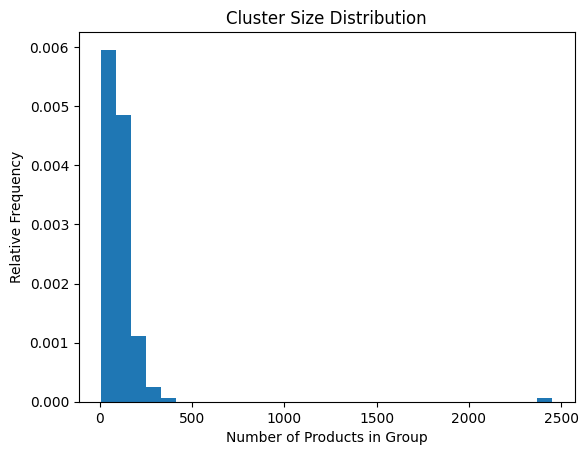

In [11]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [12]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

label
145    2452
1       385
10      316
175     312
86      302
Name: count, dtype: int64

In [13]:
# Largest Group Info
cluster_stats[134]

{'size': 69,
 'terms': ['face', 'barrel', 'cleanser', 'wash', 'face wash'],
 'sample_products': ['Spa Gift Basket for Women, Spa Luxetique Spa Kit for Women - Vanilla Scented Gift Set, 12 Pcs Relaxing Home Spa Kit with Essential Oil, Bath Salts, Body Scrub, Mother Day Gift for Mom []',
  'Fathers Day Home Spa Gift Basket, Luxury 13 Piece Bath & Body Set For Men & Women, White Rose & Jasmine Scent - Shower Gel, Bubble Bath, Body Scrub, Salts, 6 Bath Bombs, Pouf, Cosmetic Bag & Gold Tub []',
  'Mothers Day Gift Baskets - Green Canyon Spa Luxury Wicker Basket Gift Set in Lavender, 8 Pieces Premium Bath and Body Spa Work Set in Handcrafted Basket for Women Mother In Law []']}

In [15]:
products_df.to_csv("C:/Users/benja/Desktop/Improving_Mp_Search/labeled_beauty_and_personal_care_products.csv", index=False)